In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import (
    LassoCV,
    Lasso,
)


sys.path.append(os.path.abspath("../"))
from dmldid.simdata_genrater import generate_simdata_rcs, generate_simdata_rcs_fixX

# Verification with simulation data
## simulation data
-  repeated cross-section data
- true ATT := 3
- dim(X) := 10
- N = 500

In [2]:
df_rcs = generate_simdata_rcs_fixX(
    base_seed=1, N=500, Xcolumns_cnt=10, nonnull_x_cnt=3, true_att=3
)
df_rcs.head()

,unit_id,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,latent_group,latent_ps,D,Y,T
0,0,-9.158183,1.161933,-4.532897,-0.930350,-1.603513,-1.724936,12.394700,7.070890,-10.452273,-4.790106,0,0.9,0,39.009103,0
1,1,-3.828637,0.838513,-8.531369,-7.304513,3.296022,-1.154199,-8.826942,6.440126,0.611044,10.063201,0,0.9,0,46.126856,1
2,2,-6.398642,0.564814,-0.966379,3.116474,-2.249222,-13.965425,-4.981031,-1.365401,2.937855,6.069565,0,0.9,1,57.573361,0
3,3,-4.874784,0.839733,-8.429688,6.560939,7.819512,9.687644,-5.283466,5.637754,9.863194,-6.501527,0,0.9,0,40.649214,0
4,4,-4.776949,0.900822,-4.429587,1.324093,-5.327807,1.831660,-1.674586,-4.909411,-3.382856,9.890967,0,0.9,1,47.394932,0


In [3]:
y_col = "Y"
d_col = "D"
t_col = "T"
X_cols = [col for col in df_rcs.columns if "x" in col]

## Chang(2022)'s l2k model

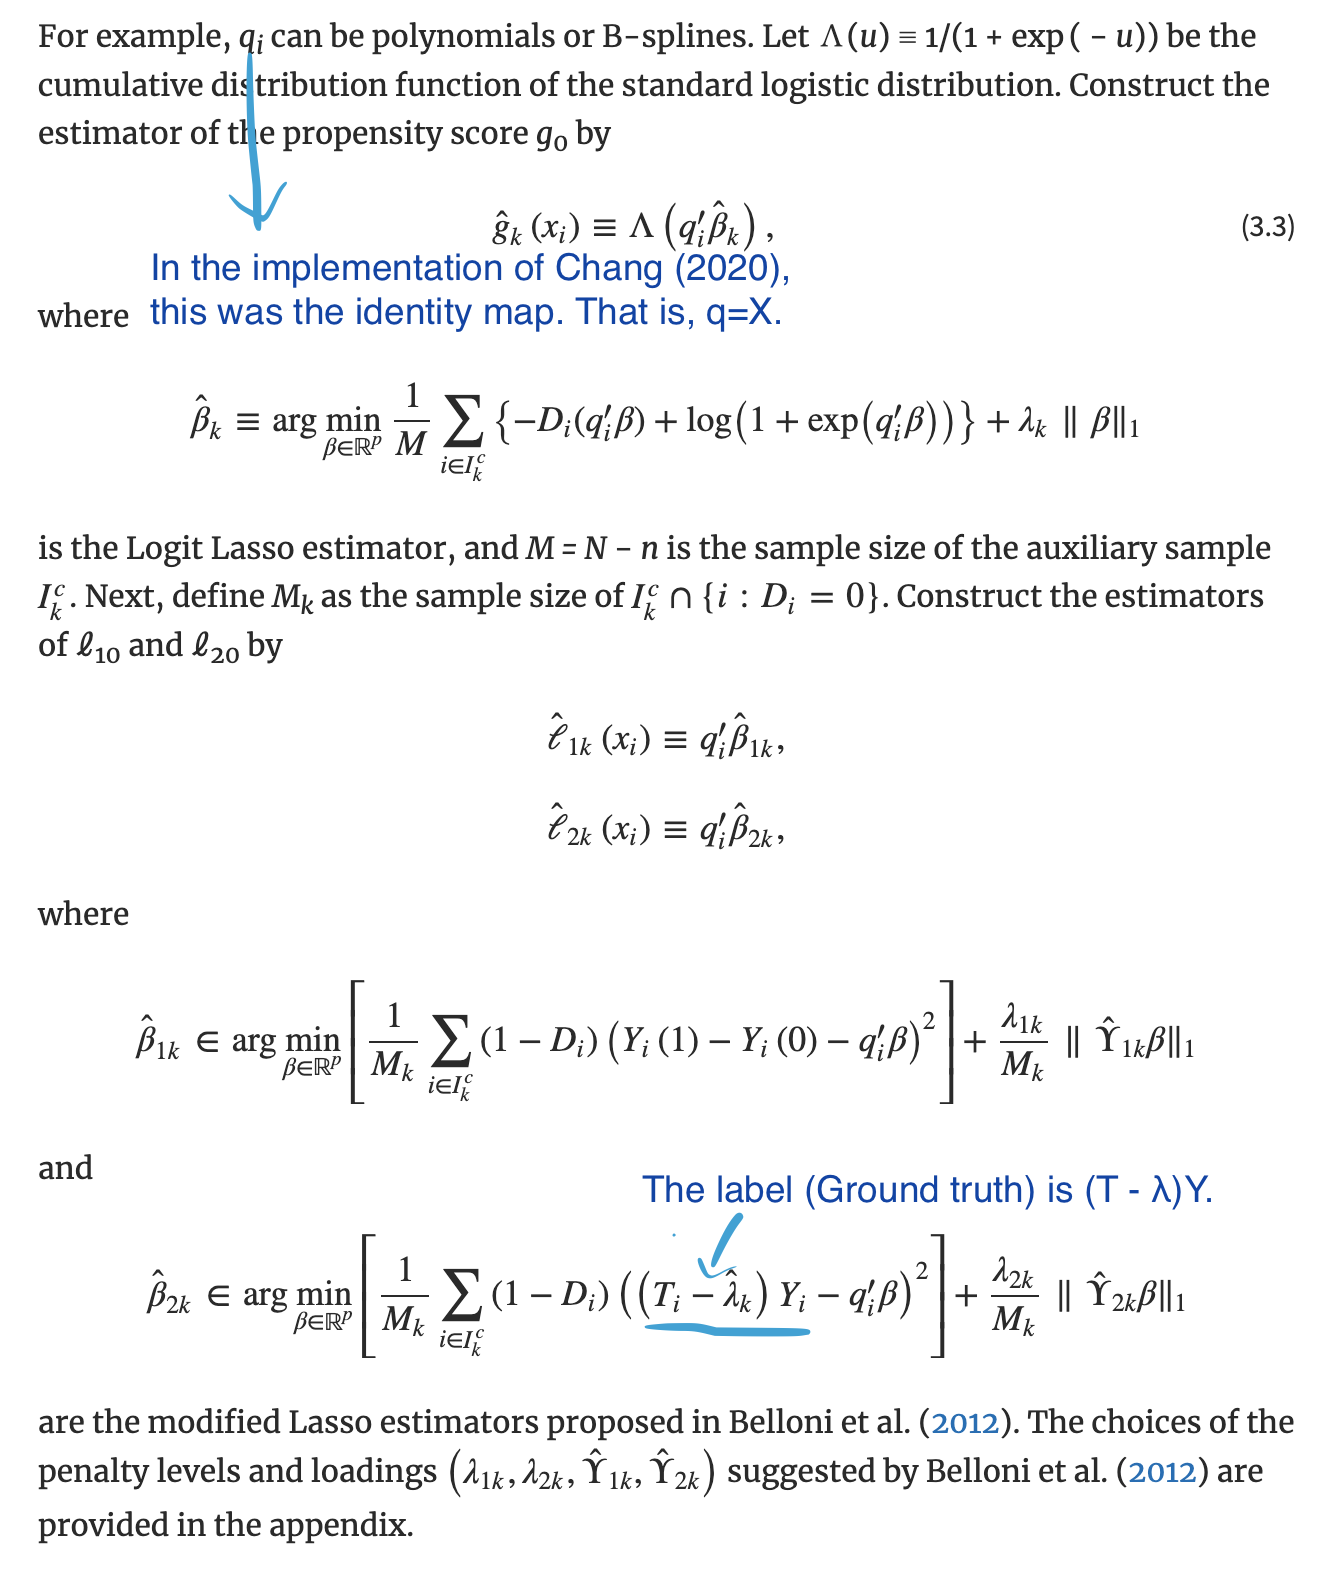

## [X -> l2k label] regression is almost nonsense
### simple example

In [4]:
hat_lambda = df_rcs["T"].mean()

control_df = df_rcs.query("D < 1")
control_df["l2k_y"] = (control_df["T"] - hat_lambda) * control_df["Y"]

In [5]:
control_df[X_cols + ["Y"]].corr()[["Y"]]

,Y
x0,0.424210
x1,0.086614
x2,0.179772
x3,-0.043216
x4,-0.050946
x5,-0.046090
x6,0.024912
x7,-0.005214
x8,-0.083989
x9,-0.087639


Text(0.5, 1.0, 'the regression(X -> l2k label) dones not make sense ')

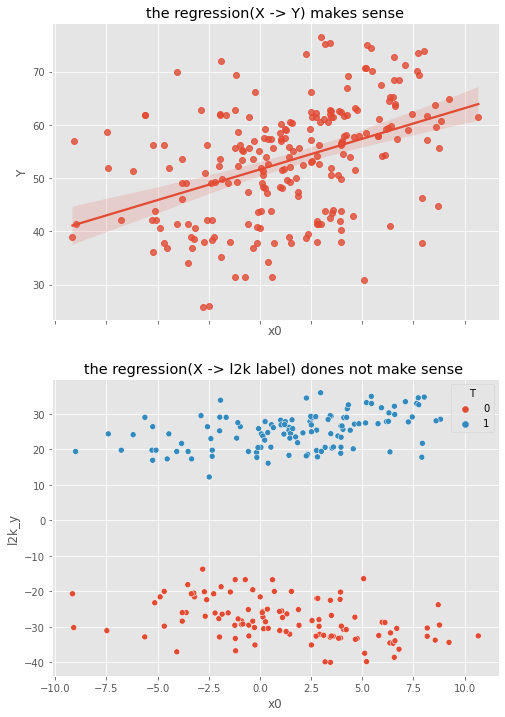

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

sns.regplot(x="x0", y="Y", data=control_df, ax=axs[0])
axs[0].set_title("the regression(X -> Y) makes sense")


sns.scatterplot(x="x0", y="l2k_y", hue="T", data=control_df, ax=axs[1])
axs[1].set_title("the regression(X -> l2k label) dones not make sense ")

## (1) simple regression result


In [7]:
x_train, x_test, y_train, y_test, l2k_y_train, l2k_y_test = train_test_split(
    control_df[X_cols],
    control_df[y_col],
    control_df["l2k_y"],
    test_size=0.3,
    random_state=0,
)


y_model = LassoCV(cv=5, random_state=0)
l2k_model = LassoCV(cv=5, random_state=0)

y_model.fit(x_train, y_train)
l2k_model.fit(x_train, l2k_y_train)

y_pred = y_model.predict(x_test)
y_mse = mean_squared_error(y_test, y_pred)

l2k_y_pred = l2k_model.predict(x_test)
l2k_mse = mean_squared_error(l2k_y_test, l2k_y_pred)

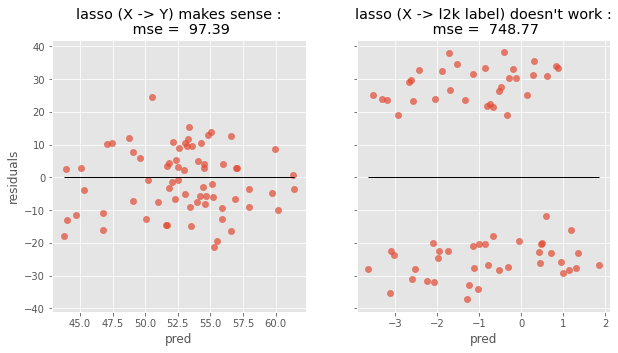

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axs[0].scatter(
    y_pred, y_pred - y_test, marker="o", s=40, alpha=0.7, label="y regression"
)
axs[0].set_xlabel("pred")
axs[0].set_ylabel("residuals")
axs[0].hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), lw=1, color="black")
axs[0].set_title(f"lasso (X -> Y) makes sense :\n mse = {y_mse : .2f}")

axs[1].scatter(
    l2k_y_pred,
    l2k_y_pred - l2k_y_test,
    marker="o",
    s=40,
    alpha=0.7,
    label="l2k regression",
)

axs[1].set_xlabel("pred")
axs[1].hlines(y=0, xmin=l2k_y_pred.min(), xmax=l2k_y_pred.max(), lw=1, color="black")
axs[1].set_title(f"lasso (X -> l2k label) doesn't work :\n mse = {l2k_mse : .2f}")

plt.show()

## (2) Is a nonlinear ML model possible?
=> No. Nothing has changed in terms of the essential issues.

In [9]:
y_model = LGBMRegressor(random_state=0)
l2k_model = LGBMRegressor(random_state=0)

y_model.fit(x_train, y_train)
l2k_model.fit(x_train, l2k_y_train)

y_pred = y_model.predict(x_test)
y_mse = mean_squared_error(y_test, y_pred)

l2k_y_pred = l2k_model.predict(x_test)
l2k_mse = mean_squared_error(l2k_y_test, l2k_y_pred)

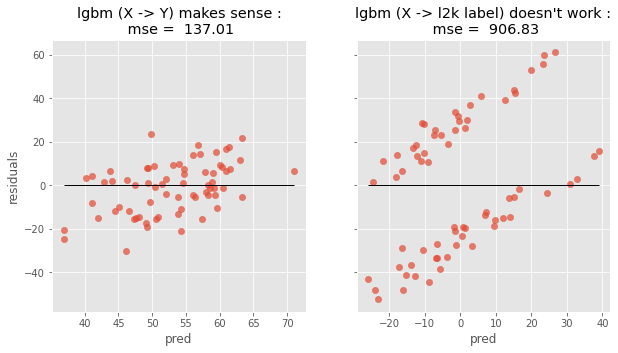

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axs[0].scatter(
    y_pred, y_pred - y_test, marker="o", s=40, alpha=0.7, label="y regression"
)
axs[0].set_xlabel("pred")
axs[0].set_ylabel("residuals")
axs[0].hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), lw=1, color="black")
axs[0].set_title(f"lgbm (X -> Y) makes sense :\n mse = {y_mse : .2f}")

axs[1].scatter(
    l2k_y_pred,
    l2k_y_pred - l2k_y_test,
    marker="o",
    s=40,
    alpha=0.7,
    label="l2k regression",
)

axs[1].set_xlabel("pred")
axs[1].hlines(y=0, xmin=l2k_y_pred.min(), xmax=l2k_y_pred.max(), lw=1, color="black")
axs[1].set_title(f"lgbm (X -> l2k label) doesn't work :\n mse = {l2k_mse : .2f}")

plt.show()

## (3) Should we put the time variable T in the features?
=> In fact, the implementation of [Chang(2020)](https://github.com/NengChiehChang/Diff-in-Diff/blob/master/Table%202/DMLML.R) shows that X contains T. 
<br>In fact, the implementation of Chang (2020) shows that X includes T
We consider it inappropriate for two reasons :
- (1) After all, it is just a linear model (Lasso) with no interaction, and the result is inappropriate.
- (2) The objective variable, `l2k_label`, contains information on T. This is a typical leakage problem

In [11]:
x_train, x_test, y_train, y_test, l2k_y_train, l2k_y_test = train_test_split(
    control_df[X_cols + [t_col]],
    control_df[y_col],
    control_df["l2k_y"],
    test_size=0.3,
    random_state=0,
)


y_model = LassoCV(cv=5, random_state=0)
l2k_model = LassoCV(cv=5, random_state=0)

y_model.fit(x_train, y_train)
l2k_model.fit(x_train, l2k_y_train)

y_pred = y_model.predict(x_test)
y_mse = mean_squared_error(y_test, y_pred)

l2k_y_pred = l2k_model.predict(x_test)
l2k_mse = mean_squared_error(l2k_y_test, l2k_y_pred)

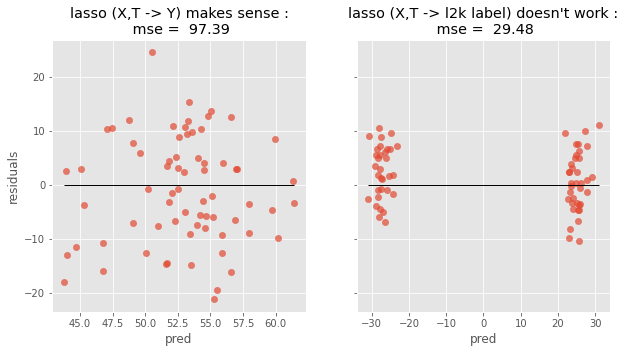

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axs[0].scatter(
    y_pred, y_pred - y_test, marker="o", s=40, alpha=0.7, label="y regression"
)
axs[0].set_xlabel("pred")
axs[0].set_ylabel("residuals")
axs[0].hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), lw=1, color="black")
axs[0].set_title(f"lasso (X,T -> Y) makes sense :\n mse = {y_mse : .2f}")

axs[1].scatter(
    l2k_y_pred,
    l2k_y_pred - l2k_y_test,
    marker="o",
    s=40,
    alpha=0.7,
    label="l2k regression",
)

axs[1].set_xlabel("pred")
axs[1].hlines(y=0, xmin=l2k_y_pred.min(), xmax=l2k_y_pred.max(), lw=1, color="black")
axs[1].set_title(f"lasso (X,T -> l2k label) doesn't work :\n mse = {l2k_mse : .2f}")

plt.show()

Based on the above results, the right one looks better.
However, it is still inappropriate in the following respects
- The nominal improvement in MSE is due to leakage.
- The predictions depend on the leakage information T, and the orthogonalization of the feature X fails.